# Assignment 2

## Machine Learning Techniques

This assignment is split into 3 sections, roughly corresponding to the contents of each of the 3 weeks in the Machine Learning module. 

All assignments are presented as Jupyter notebooks. You will fork the repository to have your own access to all files. You can edit this notebook directly with your answers and push your changes to GitHub. 

### **The goal of this assignment is to use different ML techniques to explore your data, find patterns in it, and eventually build a model that will allow us to predict stellar mass & redshift of galaxies *without doing SED fitting*.**

# Section 0: Data Preprocessing

Before we delve into machine learning, it's a good idea to look at our data, pick which sample we want to work with, etc.

The code below loads in the input data catalog:

In [153]:
from astropy.table import Table
from astropy.io import fits
with fits.open('/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/data/sw_input.fits') as f:
    df = Table(f[1].data).to_pandas()
    f.close()
    
# Display the top 3 rows of the dataframe
df.head(3)


with fits.open('/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/data/sw_output.fits') as f_out:
    df_out = Table(f_out[1].data).to_pandas()
    f_out.close()
    
# Display the top 3 rows of the dataframe
df.head(3)

,id,ra,dec,redshift,PLATE,MJD,FIBERID,designation,flux0_u,flux0_u_e,...,flux_w2_e,flux_w3,flux_w3_e,flux_w4,flux_w4_e,extin_u,extin_g,extin_r,extin_i,extin_z
0,3,337.450310,1.266134,0.088372,376,52143,404,J222948.07+011558.1,0.000031,0.000003,...,0.000049,4.172000e-07,0.000209,0.000002,0.001187,0.341327,0.265960,0.183990,0.136724,0.101698
1,5,338.115522,1.270146,0.163800,376,52143,567,J223227.69+011612.6,0.000011,0.000004,...,0.000111,9.851000e-07,0.000493,0.000004,0.001883,0.368063,0.286793,0.198402,0.147434,0.109664
2,8,341.101481,1.266255,0.143369,378,52146,404,J224424.38+011558.3,0.000017,0.000003,...,0.000039,1.013700e-06,0.000507,0.000008,0.003856,0.337630,0.263079,0.181997,0.135243,0.100596


#### Question 1

Look at all the column names. Choose which columns have *meaningful* data, i.e. have data we want to use in our machine learning to predict stellar mass and/or redshift. Why did you choose these ones?

In [154]:
import numpy as np
import matplotlib.pyplot as plt

***Answer:*** I think that the optical fluxes will have the most data, and I will use the corrected fluxes. I may or may not use IR fluxes as well, but we will see! I will choose these parameters later in the code. I will also remove galaxies with no flux in any band, those with 9.999 in any band, and those with bad flags.



#### Question 2

Choose a reasonably-sized subset of your data ($10^3 \sim 10^4$ or so galaxies)<br>
Make sure to save your subset, or at least the IDs you chose, for later - you will need them!

In [163]:
length = len(df)
print(length)
print(np.sum(df==0.))
rows1, cols1 = np.where((df==9.999) | (df==0.) )
rows1 = np.unique(rows1)
all_inds1 = np.arange(0, len(df),1).astype(int)
new_df_first = df.loc[np.delete(all_inds1, rows1)]
new_df_out_first = df_out.loc[np.delete(all_inds1, rows1)]

flags = new_df_out_first['flag']==1

new_df = new_df_first[flags]
new_df_out = new_df_out_first[flags]

np.random.seed(69)
sample_inds = np.random.choice(range(len(new_df)), size=8000, replace=False)
sample = new_df.iloc[sample_inds]
sample_out = new_df_out.iloc[sample_inds]

print(new_df.shape)

858365
id                 0
ra                 0
dec                0
redshift         748
PLATE              0
MJD                0
FIBERID            0
designation        0
flux0_u        15086
flux0_u_e          0
flux0_g          155
flux0_g_e          0
flux0_r           47
flux0_r_e          0
flux0_i           99
flux0_i_e          0
flux0_z          102
flux0_z_e          0
flux0_w1           0
flux0_w1_e         0
flux0_w2           0
flux0_w2_e         0
flux0_w3           0
flux0_w3_e         0
flux0_w4           0
flux0_w4_e         0
flux_u         15511
flux_u_e       15410
flux_g           156
flux_g_e         104
flux_r            45
flux_r_e          10
flux_i            99
flux_i_e          52
flux_z           100
flux_z_e          99
flux_w1            0
flux_w1_e          0
flux_w2            0
flux_w2_e          0
flux_w3            0
flux_w3_e          0
flux_w4            0
flux_w4_e          0
extin_u            0
extin_g            0
extin_r            0
extin_

/home/cameron/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


(211526, 49)


#### Question 3

It is often useful (and sometimes required) to *normalize* your data, i.e. for each parameter, subtract the mean of that parameter from each point in the sample, and divide by the standard deviation. For example, for mass, for each galaxy $i$, you can calculate

$$ M_{norm, i} = \frac{M_i - \langle M \rangle}{\sigma_M}$$

There are other ways to pre-process data (e.g., normalize by quantiles, or redefine variables such that they match some distribution).

* For each column you chose, normalize the data in your sample in some way.
* For one parameter, make a histogram of the original data, and the data after normalization. Do the histograms look as you expected them to?

***Answer:*** The histogram of flux values normalized by the standard deviation look as expected. They are very skewed because there are more faint objects than bright ones.

0.0009684389855101472


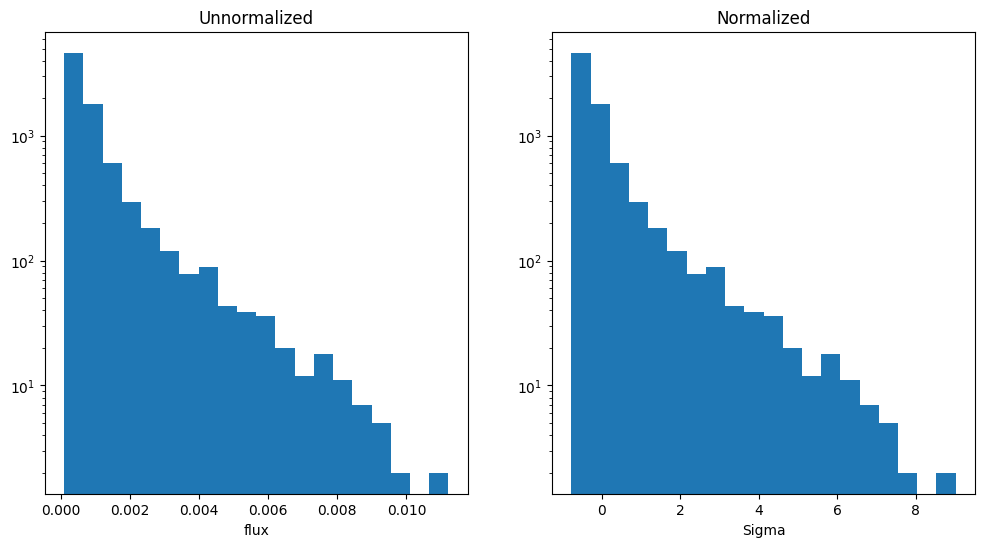

In [165]:
def norm_by_mean_std(data):
    mean = np.mean(data)
    std = np.std(data)
    print(mean)
    norm_data = (data-mean)/std
    return norm_data


flux_r = np.array(sample['flux_r'], dtype=float)

flux_r_norm = norm_by_mean_std(flux_r)

hist_flux_r, bins_flux_r = np.histogram(flux_r, bins=20)
bin_width_flux_r = bins_flux_r[1] - bins_flux_r[0]
hist_flux_r_norm, bins_flux_r_norm = np.histogram(flux_r_norm, bins=20)
bin_width_flux_r_norm = bins_flux_r_norm[1] - bins_flux_r_norm[0]

fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,6))
ax.bar(bins_flux_r[:-1] + bin_width_flux_r/2.0, hist_flux_r, width=bin_width_flux_r)
ax2.bar(bins_flux_r_norm[:-1] + bin_width_flux_r_norm/2.0, hist_flux_r_norm, width=bin_width_flux_r_norm)
ax.set_yscale('log')
ax.set_title('Unnormalized')
ax.set_xlabel('flux')
ax2.set_yscale('log')
ax2.set_title('Normalized')
ax2.set_xlabel('Sigma')
plt.show()

# Section 1: Data Compression

#### Question 1

What is a dimensionality reduction technique? Why would you use one?

***Answer:*** A dimensionality reduction technique reduces multi dimensional data to less dimensions without losing important information that defines the data. This would be the case with maximally informative dimensions for example.

#### Question 2

There are many different data compression techniques: PCA, UMAP, tSNE, VAE... Pick two of these methods, and explain briefly: 
* How do each one of them work?
* What are advantages or disadvantages of each method?
* When would you use one over the other?

***Answer:*** PCA creates linear combinations of input variables to reduce the dimensions in the output. It ensures that the output variables are uncorrelated with each other. Reducing the number of variables allows you to predict an output with less computing power. 

UMAP is slower than PCA but is based on manifold learning techniques (tbh I don't know what that means). My understanding is that the reduced-dimensionality plot of the data will be structurally similar to the high dimensionality one. This seems more robust than PCA, but at the expense of computing time.

#### Question 3

Pick one of the dimensionality reduction method

> Most already have easy-to-use implementations so you don't have to code them from scratch: [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [UMAP](https://umap-learn.readthedocs.io/en/latest/index.html), [tSNR](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Training something like a Variational Autoencoder is a more involved task and requires access to a GPU.

Do the following:    
1. Reduce your data to 2 dimensions using your chosen algorithm
2. Save your output
    > Remember to keep the IDs with the principal components, so that you can easily see which galaxy those values are for later
3. Plot the two principal variables against each other and describe what you see
    * Are there any obvious patterns in your data?
    * Are there any clusters?!

In [171]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import umap

reducer = umap.UMAP(n_neighbors=10)

# good_data = sample[['flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_w1', 'flux_w2', 'flux_w3', 'flux_w4', 'extin_u', 'extin_g', 'extin_r', 'extin_i', 'extin_z']].values
# good_data = sample[['flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_w1', 'flux_w2', 'flux_w3', 'flux_w4']].values #, 'flux_w3', 'flux_w4']].values
# good_data = sample[['flux0_g', 'flux0_r', 'flux0_i', 'flux0_z', 'flux0_w1', 'flux0_w2', 'flux0_w3', 'flux0_w4', 'extin_g', 'extin_r', 'extin_i', 'extin_z']].values

# good_data = sample[['flux0_g', 'flux0_r', 'flux0_i', 'flux0_z', 'flux0_w1', 'flux0_w2', 'flux0_w3', 'flux0_w4', 'extin_g', 'extin_r', 'extin_i', 'extin_z']].values

good_data = sample[['flux_u','flux_g', 'flux_r', 'flux_i', 'flux_z', 
                    'flux_u_e','flux_g_e', 'flux_r_e', 'flux_i_e', 'flux_z_e']].values #, 'flux_w3', 'flux_w4']].values


print(good_data.shape)

# good_data = np.log10(good_data)


means = np.mean(good_data,axis=0)
print(means)
stds = np.std(good_data, axis=0)

# scaled_good_data = (good_data - means) / stds
scaled_good_data = RobustScaler().fit_transform(good_data)


embedding = reducer.fit_transform(scaled_good_data)
embedding.shape

(8000, 10)
[1.5913470e-04 5.1533518e-04 9.6843898e-04 1.3675010e-03 1.7695598e-03
 1.0808846e-05 2.6068701e-05 4.8578873e-05 6.8439665e-05 8.8518886e-05]


(8000, 2)

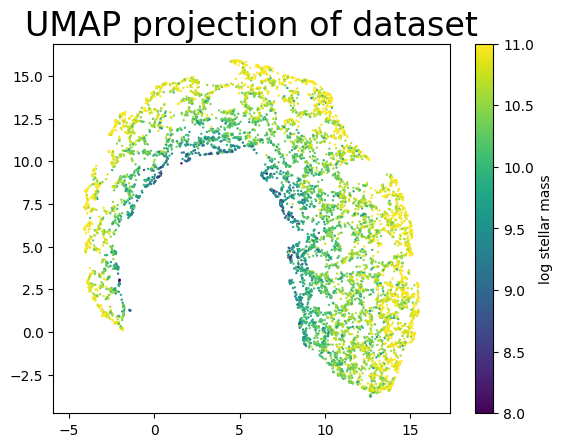

In [172]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=sample_out.lmass50_all, vmin=8, vmax=11, marker='.', s=2)
plt.colorbar(label='log stellar mass')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of dataset', fontsize=24);

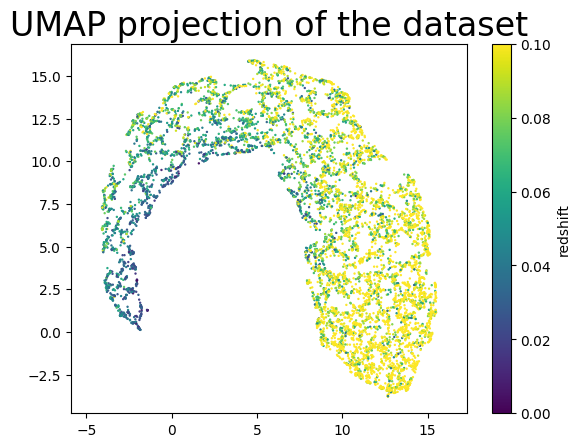

In [173]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=sample.redshift, vmin=0, vmax=0.1, marker='.', s=2)
plt.colorbar(label='redshift')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24);

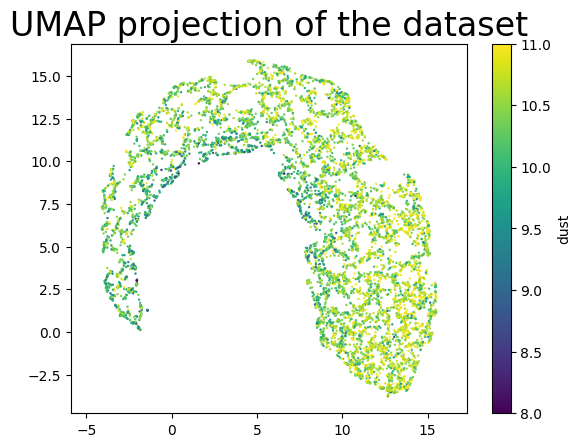

In [174]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=sample_out.ldust50_all, vmin=8, vmax=11, marker='.', s=2)
plt.colorbar(label='dust')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24);

***Answer for Questions 3 and 4:*** In this case I have chosen to use the optical fluxes and their errors. While there is not a lot of great clustering in my UMAP plot, there are clear patterns. When the points are coloured by stellar mass, there is a clear gradient in the manifold shape, where lower stellar mass values tend to be along one edge and higher stellar mass values tend to be along the other edge. This implies that the y-axis UMAP parameter describes the stellar mass quite well. When the points are coloured by redshift, the x-axis parameter describes the redshift quite well, with points toward the left of the plot being lower in redshift and points toward the right being higher redshift. When plotting the dust parameter, there is not much of a trend.

#### Question 4

Now, load in the `sw_output.fits` table and cross-match the two tables to get stellar masses, redshifts, dust opacities, etc.

7. Color the points on your plot above by a physical property and discuss if you see any patterns.

***Answer:*** See above

#### Question 5 [bonus]

If you are feeling brave, you can try several encoding tools - how do your results change? What if you keep more than 2 principal variables? Does changing *hyperparameters* of your algorithm change your results quantitatively / qualitatively?


# Section 2: Unsupervised ML

In section, you will implement a clustering algorithm to see if there are any *natural* clusters in your data. You can choose any algorithm from the ones shown [on the Scikit-Learn website](https://scikit-learn.org/stable/modules/clustering.html). The best algorithm depends on your data: so refer back to the plots you made in Section 1 to see which algorithm you think will work best. 

Load in the subset you chose in the previous section. 

In [ ]:
# Space for code

#### Question 1

Choose a clustering algorithm. Why did you go for this particular one?

***Answer:*** I really only have one substanital cluster, yet there are clear trends. Ideally I would like to be able to cut the manifold down the middle to separate high and low stellar mass galaxies, but since galaxies stellar masses are not discretized and binary this likely doesn't make sense. I will try it anyway with 3 clusters using spectral clustering and see what happens! I suspect I will be able to separate high and low redshift things well, since the redshift gradient is across the manifold instead of through it (that doesn't make sense but I think you see what I mean).

#### Question 2

Run clustering on your **compressed data**. Think of these questions, if they are relevant to your algorithm - often the *hyperparameters* of your algorithm will need you to answer these.

* How many clusters should you fit to your data?
* Where should the initial guesses for the cluster centers be?
* What should be the typical size for each cluster?


In [180]:
from sklearn.cluster import SpectralClustering, KMeans
SC_20 = SpectralClustering(n_clusters=20,
       assign_labels='discretize',
      random_state=0)
SC_20.fit(embedding)  

SC_3 = SpectralClustering(n_clusters=3,
       assign_labels='discretize',
      random_state=0)
SC_3.fit(embedding) 

SpectralClustering(assign_labels='discretize', n_clusters=3, random_state=0)

***Answer:*** I am not expecting great results here, so I am running very basic spectral clustering with 3 and 20 clusters.

#### Question 3

Plot your compressed data, coloring the points by which cluster they belong it.
Optionally, you can also overplot the boundaries of your cluster (see the example [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#visualize-the-results-on-pca-reduced-data)).

* Do the clusters make sense?
* Do you think you chose the right number of clusters?

You can use this visualization to tune the hyper-parameters of your clustering algorithm to perhaps get a cleaner result.

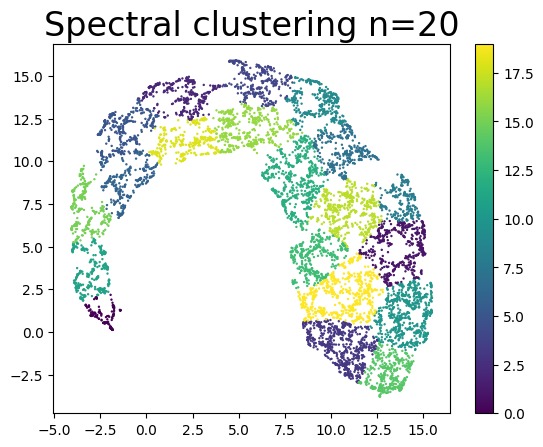

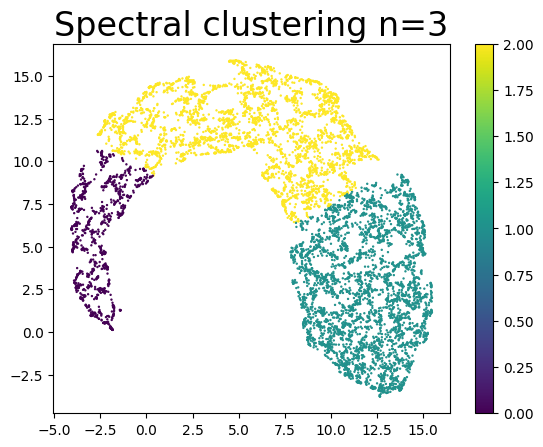

In [181]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=SC_20.labels_, marker='.', s=2)
plt.colorbar()
plt.title('Spectral clustering n=20', fontsize=24);
plt.show()

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=SC_3.labels_, marker='.', s=2)
plt.colorbar()
plt.title('Spectral clustering n=3', fontsize=24);

***Answer:*** Spectral clustering with n=3 separates things based on redshift, as expected. If I increase the clusters to 20, there may be some separation of both redshift and mass, but it kind of feels like I'm over-clustering continuous data.

#### Question 4

Look at the distribution of *physical properties* (mass, redshift, dust...) from the output catalog for each one of your clusters. Are there any statistically significant differences between the clusters in any of these properties?

dust
label, mean, stdev
0 10.127248 0.5557927
1 10.527568 0.46342322
2 10.35606 0.52390397


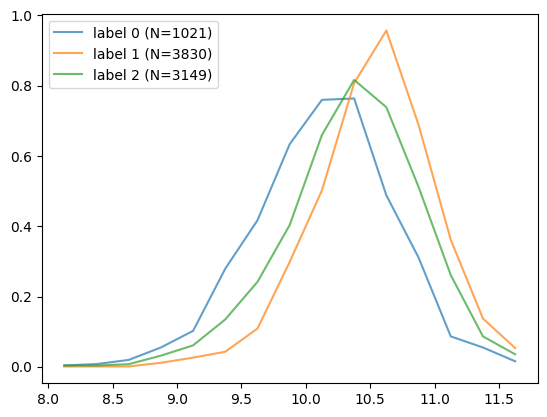



mass
label, mean, stdev
0 10.485309 0.63912004
1 10.47728 0.4761802
2 10.398958 0.5957744


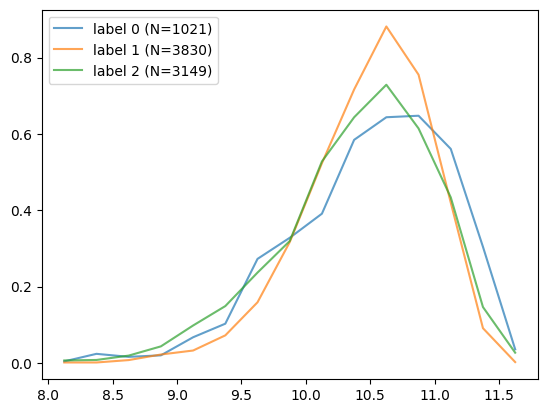



redshift
label, mean, stdev
0 0.045041764930656224 0.020739705075682367
1 0.11504059577274152 0.03830847776115636
2 0.08037690948551922 0.033709173490424515


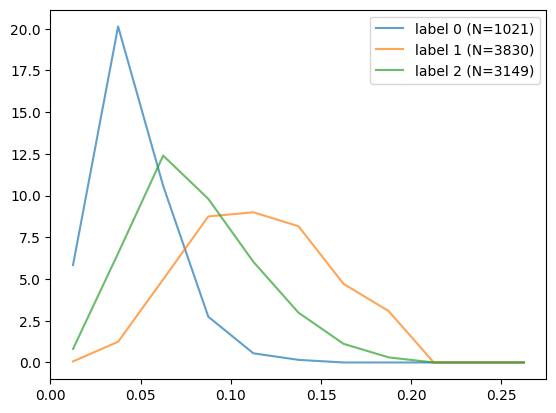

In [182]:
dust = sample_out.ldust50_all
print('dust')
print('label, mean, stdev')

# fig, axs = plt.subplots(1,3, figsize=(12,4))
for i in range(len(np.unique(SC_3.labels_))):
    label = np.unique(SC_3.labels_)[i]
    dust_sub = dust[SC_3.labels_==label]
    print(label, np.mean(dust_sub), np.std(dust_sub))
    hist, bin_edges = np.histogram(dust_sub, bins=np.arange(8,12,0.25), density=True)
    # axs[i].bar(bin_edges[:-1]+0.125, hist, width=0.25)
    plt.plot(bin_edges[:-1]+0.125, hist,alpha=0.7, label='label ' + str(label)+ ' (N=' + str(len(dust_sub)) + ')')
plt.legend()
plt.show()

print('\n')

print('mass')
print('label, mean, stdev')
mass = sample_out.lmass50_all
for i in range(len(np.unique(SC_3.labels_))):
    label = np.unique(SC_3.labels_)[i]
    mass_sub = mass[SC_3.labels_==label]
    print(label, np.mean(mass_sub), np.std(mass_sub))
    hist, bin_edges = np.histogram(mass_sub, bins=np.arange(8,12,0.25), density=True)
    # axs[i].bar(bin_edges[:-1]+0.125, hist, width=0.25)
    plt.plot(bin_edges[:-1]+0.125, hist,alpha=0.7, label='label ' + str(label) + ' (N=' + str(len(mass_sub)) + ')')
plt.legend()
plt.show()


print('\n')
print('redshift')
print('label, mean, stdev')
redshift = sample.redshift
for i in range(len(np.unique(SC_3.labels_))):
    label = np.unique(SC_3.labels_)[i]
    redshift_sub = redshift[SC_3.labels_==label]
    print(label, np.mean(redshift_sub), np.std(redshift_sub))
    hist, bin_edges = np.histogram(redshift_sub, bins=np.arange(0,0.3,0.025), density=True)
    # axs[i].bar(bin_edges[:-1]+0.125, hist, width=0.25)
    plt.plot(bin_edges[:-1]+0.0125, hist,alpha=0.7, label='label ' + str(label)+ ' (N=' + str(len(redshift_sub)) + ')')
plt.legend()
plt.show()




***Answer:*** Just doing this for n=3 for simplicity. As expected, the three clusters have similar distributions of mass and dust, but different redshift distributions.

#### Question 5

Repeat **questions 2 and 4** but using your full dataset instead of the compressed one. 
* Do you see any differences in your results?
* Did you need to choose different hyperparameters?


In [184]:
SC_full = SpectralClustering(n_clusters=3,
       assign_labels='discretize',
      random_state=0)
SC_full.fit(good_data) 

SpectralClustering(assign_labels='discretize', n_clusters=3, random_state=0)

dust
label, mean, stdev
0 9.969649 0.58368504
1 10.4871 0.47434682
2 10.315034 0.49549946


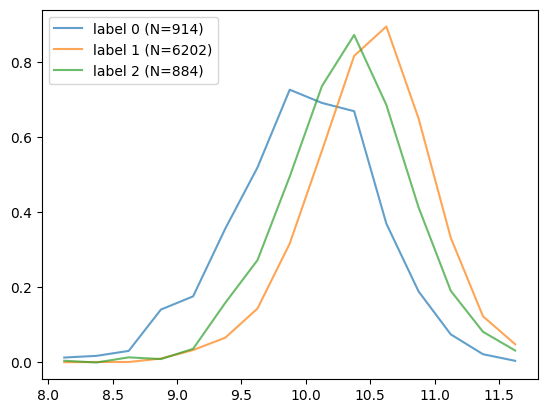



mass
label, mean, stdev
0 9.878314 0.5827724
1 10.469139 0.49521717
2 10.883959 0.36332482


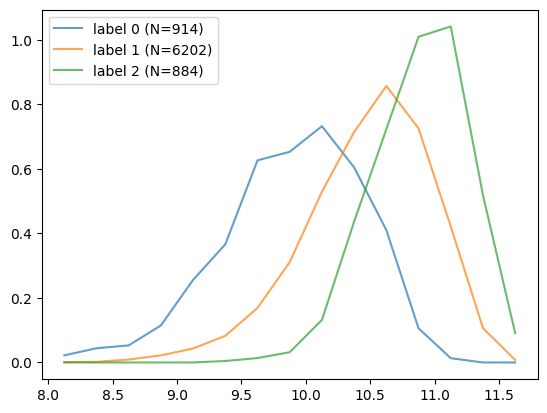



redshift
label, mean, stdev
0 0.04354781108129102 0.01983638425640811
1 0.10428913404851661 0.03895867686540279
2 0.060063465018665156 0.025860993420200824


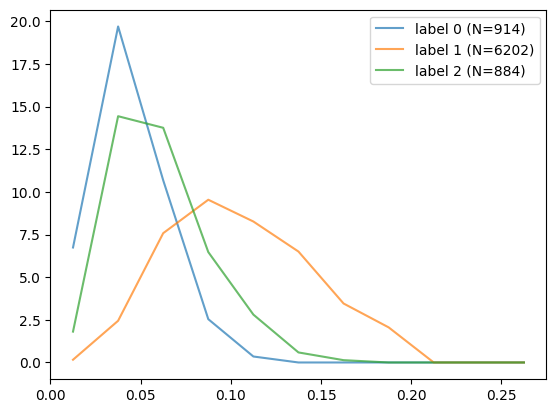

In [185]:
dust = sample_out.ldust50_all
print('dust')
print('label, mean, stdev')

# fig, axs = plt.subplots(1,3, figsize=(12,4))
for i in range(len(np.unique(SC_full.labels_))):
    label = np.unique(SC_full.labels_)[i]
    dust_sub = dust[SC_full.labels_==label]
    print(label, np.mean(dust_sub), np.std(dust_sub))
    hist, bin_edges = np.histogram(dust_sub, bins=np.arange(8,12,0.25), density=True)
    # axs[i].bar(bin_edges[:-1]+0.125, hist, width=0.25)
    plt.plot(bin_edges[:-1]+0.125, hist,alpha=0.7, label='label ' + str(label)+ ' (N=' + str(len(dust_sub)) + ')')
plt.legend()
plt.show()

print('\n')

print('mass')
print('label, mean, stdev')
mass = sample_out.lmass50_all
for i in range(len(np.unique(SC_full.labels_))):
    label = np.unique(SC_full.labels_)[i]
    mass_sub = mass[SC_full.labels_==label]
    print(label, np.mean(mass_sub), np.std(mass_sub))
    hist, bin_edges = np.histogram(mass_sub, bins=np.arange(8,12,0.25), density=True)
    # axs[i].bar(bin_edges[:-1]+0.125, hist, width=0.25)
    plt.plot(bin_edges[:-1]+0.125, hist,alpha=0.7, label='label ' + str(label) + ' (N=' + str(len(mass_sub)) + ')')
plt.legend()
plt.show()


print('\n')
print('redshift')
print('label, mean, stdev')
redshift = sample.redshift
for i in range(len(np.unique(SC_full.labels_))):
    label = np.unique(SC_full.labels_)[i]
    redshift_sub = redshift[SC_full.labels_==label]
    print(label, np.mean(redshift_sub), np.std(redshift_sub))
    hist, bin_edges = np.histogram(redshift_sub, bins=np.arange(0,0.3,0.025), density=True)
    # axs[i].bar(bin_edges[:-1]+0.125, hist, width=0.25)
    plt.plot(bin_edges[:-1]+0.0125, hist,alpha=0.7, label='label ' + str(label)+ ' (N=' + str(len(redshift_sub)) + ')')
plt.legend()
plt.show()





***Answer:*** When I use spectral clustering on the full data set instead of the compressed one, I clearly get different clusters. There is a bit of separation between dust in the three clusters now, a substantial separation between stellar mass in the three bins, and one cluster has a different redshift distribution than the other two.

# Section 3: Supervised ML

Finally, we can use *supervised ML* to train an algorithm that predicts our relevant physical parameters (mass, redshift, etc.) from the input data directly. This is a regression task, since we want to predict a continuous variable.

You should aim to **predict mass and redshift** of galaxies, but you can also try to predict more properties available in the output catalog.

#### Question 1

Choose a regression tool (e.g., a linear model, SVM, neural network, gaussian process, decision tree... see [more examples here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)).

Why did you choose this particular one? 

* You can either train N different models for mass, redshift, etc.; or you can train a single model that predicts N parameters simultaneously.
* Think: how many variables do you want to predict, what does your data look like, what relationship do you see by eye between your input and output data...



***Answer:*** I am going to choose to use linear regression using the optical fluxes. I suspect (from previous experiences) that using the log of optical fluxes (i.e. magnitudes) can predict stellar masses quite well.

If this goes well, I will try to predict redshift as well.

#### Question 2

Split your data into two sub-samples: one for training and one for validation

Use the tool you chose to predict the physical parameters from the input *training* data.

* Optimize the parameters of the model
* What is the correlation between predicted mass/redshift/other parameters, or the errors in the predictions?


(7000, 10) (7000, 2)
-0.016392449 0.27915806
-0.0009371406700921475 0.024904851290830015


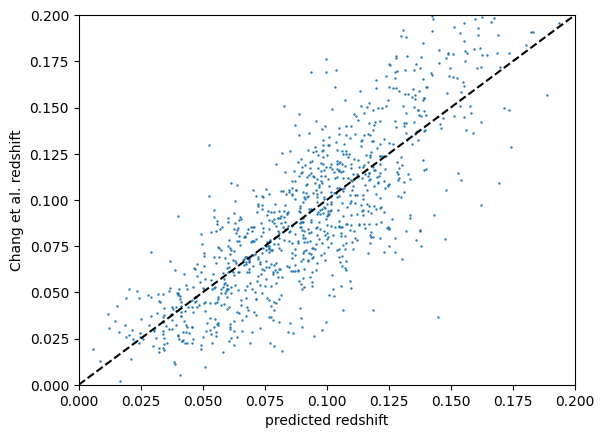

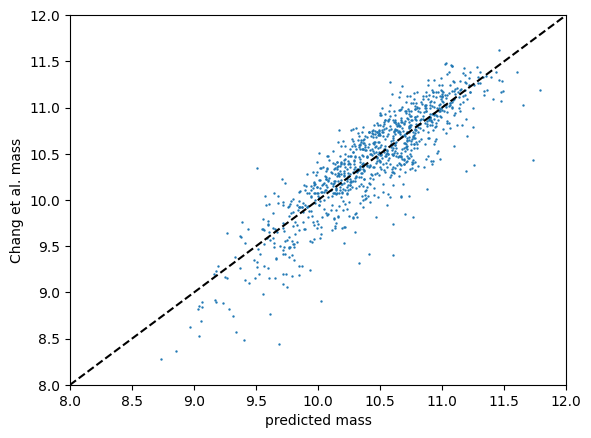

In [196]:
import numpy as np
from sklearn.linear_model import LinearRegression

# good_data = sample[['flux_u','flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_w1', 'flux_w2', 'flux_w3', 'flux_w4']].values 

# good_data = np.log10(sample[['flux_g', 'flux_r']].values) 

good_data = np.log10(sample[['flux_u','flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_u_e','flux_g_e', 'flux_r_e', 'flux_i_e', 'flux_z_e']].values) 

train_sample_in = good_data[:7000,:]
train_sample_mass = sample_out['lmass50_all'][:7000]
train_sample_redshift = sample['redshift'][:7000]

test_sample_in = good_data[7000:,:]
test_sample_mass = sample_out['lmass50_all'][7000:]
test_sample_redshift = sample['redshift'][7000:]

X = train_sample_in
y = np.array([train_sample_mass, train_sample_redshift]).T
print(X.shape, y.shape)

reg = LinearRegression().fit(X, y)

test_reg = reg.predict(test_sample_in)
test_reg_mass = test_reg[:, 0]
test_reg_redshift = test_reg[:, 1]


mean_from_line_mass = np.mean(test_sample_mass-test_reg_mass)
rms_mass = np.sqrt(np.mean((test_sample_mass-test_reg_mass)**2))
print(mean_from_line_mass, rms_mass)


mean_from_line_redshift = np.mean(test_sample_redshift-test_reg_redshift)
rms_redshift = np.sqrt(np.mean((test_sample_redshift-test_reg_redshift)**2))
print(mean_from_line_redshift, rms_redshift)

plt.scatter(test_reg_redshift, test_sample_redshift, marker='.', s=2)
plt.xlabel('predicted redshift')
plt.ylabel('Chang et al. redshift')
plt.plot([0,0.2], [0,0.2], linestyle='--', color='k')
plt.xlim([0,0.2])
plt.ylim([0,0.2])
plt.show()

plt.scatter(test_reg_mass, test_sample_mass, marker='.', s=2)
plt.xlabel('predicted mass')
plt.ylabel('Chang et al. mass')
plt.plot([7,12], [7,12], linestyle='--', color='k')
plt.xlim([8,12])
plt.ylim([8,12])
plt.show()



#### Question 3

Use your model to predict the physical parameters of your validation sample

* What is the accuracy? Is the model performing as well as you expected?

***Answer:*** See plot above. Using linear regression on the log of the optical fluxes and errors worked quite well (even though logging the errors is not proper error propogation). After training on 7000/8000 galaxies I am able to predict the stellar mass and redshifts using the same model of the other 1000 quite well. The bias and rms in the predicted masses are -0.016dex and 0.28dex and for redshift are -0.0009 and 0.025. 


#### Question 4

Load in `test_sample.csv` and use your model to predict physical parameters.

* What is the accuracy? Is the model performing as well as you expected?
* Why do you think the performance is what it is?

(54, 49)
(7000, 10) (7000, 2)
0.29467982 0.88223016
0.03333691335375295 0.07111662003240679


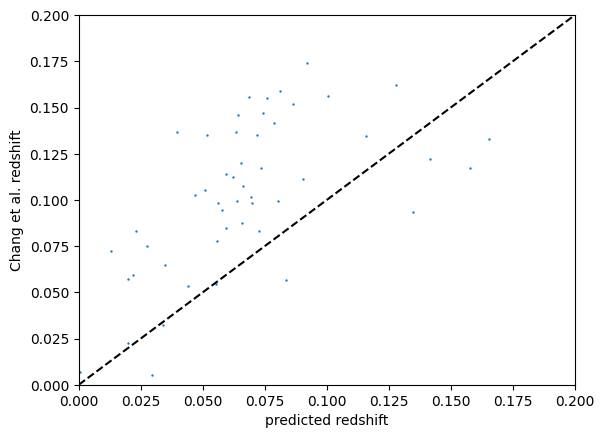

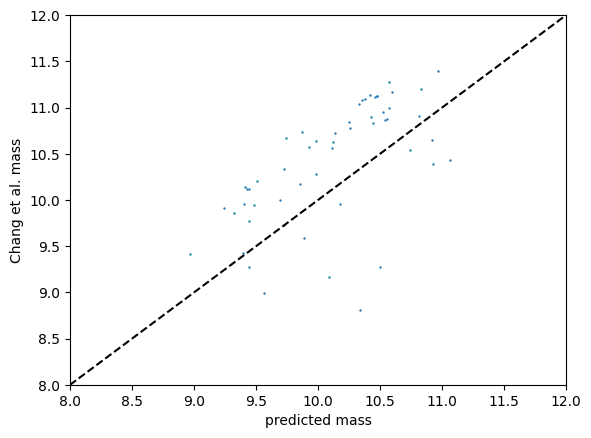

In [197]:
import pandas as pd

df_test = pd.read_csv('/mnt/c/users/camer/OneDrive - University of Waterloo/Grad School/PHYS 788/UWAstroStats/projects/sed-fitting/test_sample.csv')


gals = df_test['id'].values
df_test_gals = df[df.id.isin(gals)]
df_test_out_gals = df_out[df_out.id.isin(gals)]
# print(df_test_out_gals)


rows1, cols1 = np.where((df_test_gals==9.999) | (df_test_gals==0.) )
rows1 = np.unique(rows1)
all_inds1 = np.arange(0, len(df_test_gals),1).astype(int)

# print(df_test_gals)

new_df_first = df_test_gals.iloc[np.delete(all_inds1, rows1)]
new_df_out_first = df_test_out_gals.iloc[np.delete(all_inds1, rows1)]

print(new_df_first.shape)


good_data_test = np.log10(new_df_first[['flux_u','flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_u_e','flux_g_e', 'flux_r_e', 'flux_i_e', 'flux_z_e']].values) 
good_data_mass_test = new_df_out_first[['lmass50_all']].values
good_data_redshift_test = new_df_first[['redshift']].values




test_sample_in = good_data_test
test_sample_mass = good_data_mass_test
test_sample_redshift = good_data_redshift_test

X = train_sample_in
y = np.array([train_sample_mass, train_sample_redshift]).T
print(X.shape, y.shape)

reg = LinearRegression().fit(X, y)

test_reg = reg.predict(test_sample_in)
test_reg_mass = test_reg[:, 0]
test_reg_redshift = test_reg[:, 1]


mean_from_line_mass = np.mean(test_sample_mass-test_reg_mass)
rms_mass = np.sqrt(np.mean((test_sample_mass-test_reg_mass)**2))
print(mean_from_line_mass, rms_mass)


mean_from_line_redshift = np.mean(test_sample_redshift-test_reg_redshift)
rms_redshift = np.sqrt(np.mean((test_sample_redshift-test_reg_redshift)**2))
print(mean_from_line_redshift, rms_redshift)

plt.scatter(test_reg_redshift, test_sample_redshift, marker='.', s=2)
plt.xlabel('predicted redshift')
plt.ylabel('Chang et al. redshift')
plt.plot([0,0.2], [0,0.2], linestyle='--', color='k')
plt.xlim([0,0.2])
plt.ylim([0,0.2])
plt.show()

plt.scatter(test_reg_mass, test_sample_mass, marker='.', s=2)
plt.xlabel('predicted mass')
plt.ylabel('Chang et al. mass')
plt.plot([7,12], [7,12], linestyle='--', color='k')
plt.xlim([8,12])
plt.ylim([8,12])
plt.show()


***Answer:*** The model does not predict the masses and redshift for these test galaxies. Note that I removed galaxies with 9.999 or 0 flux, which left only 54 galaxies. This was necessary though since I'm logging the fluxes. There is a clear bias in both measurements (0.29dex and 0.033 respectively) and a lot of scatter, particularly in the masses. This sample of galaxies may be very dusty or something. Using optical fluxes to predict masses without any information about dust would essentially assume some average dust profile (if modelling), and in this case would essentially be doing the same assuming the training set were not biased to be dusty or not dusty. If a set of dustier-than-normal galaxies were given the masses and redshifts could be poorly predicted.

#### Question 5 [bonus]

Repeat steps 1-4 for the *compressed* dataset. Do you see any differences in performance?

In [ ]:
# Placeholder

#### Question 6 [bonus]

Think back to the results you got from clustering. Does the model work equally well for galaxies in the different clusters?

In [ ]:
# Placeholder